In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Upload the file to work with
from google.colab import files
uploaded = files.upload()

Saving UsArrests.csv to UsArrests (1).csv


In [27]:
# Load the dataset
df = pd.read_csv("UsArrests.csv")
print(df.shape)
df.head()

(50, 5)


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


First, I checked the dataset missing values ​​(none were found).

The use of normalization (standardization) is that all items (murder, assault, rape, urban pop) are at the same scale, since PCA and clustering methods are sensitive to different scales

In [28]:
# Check missing values
df.isnull().sum()

,0
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [29]:
print(df.describe())

         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Before performing PCA I need to scale the data by using StandardScaler

In [32]:
# Drop irrelevent columns
df.drop("City", axis=1, inplace=True)
df.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


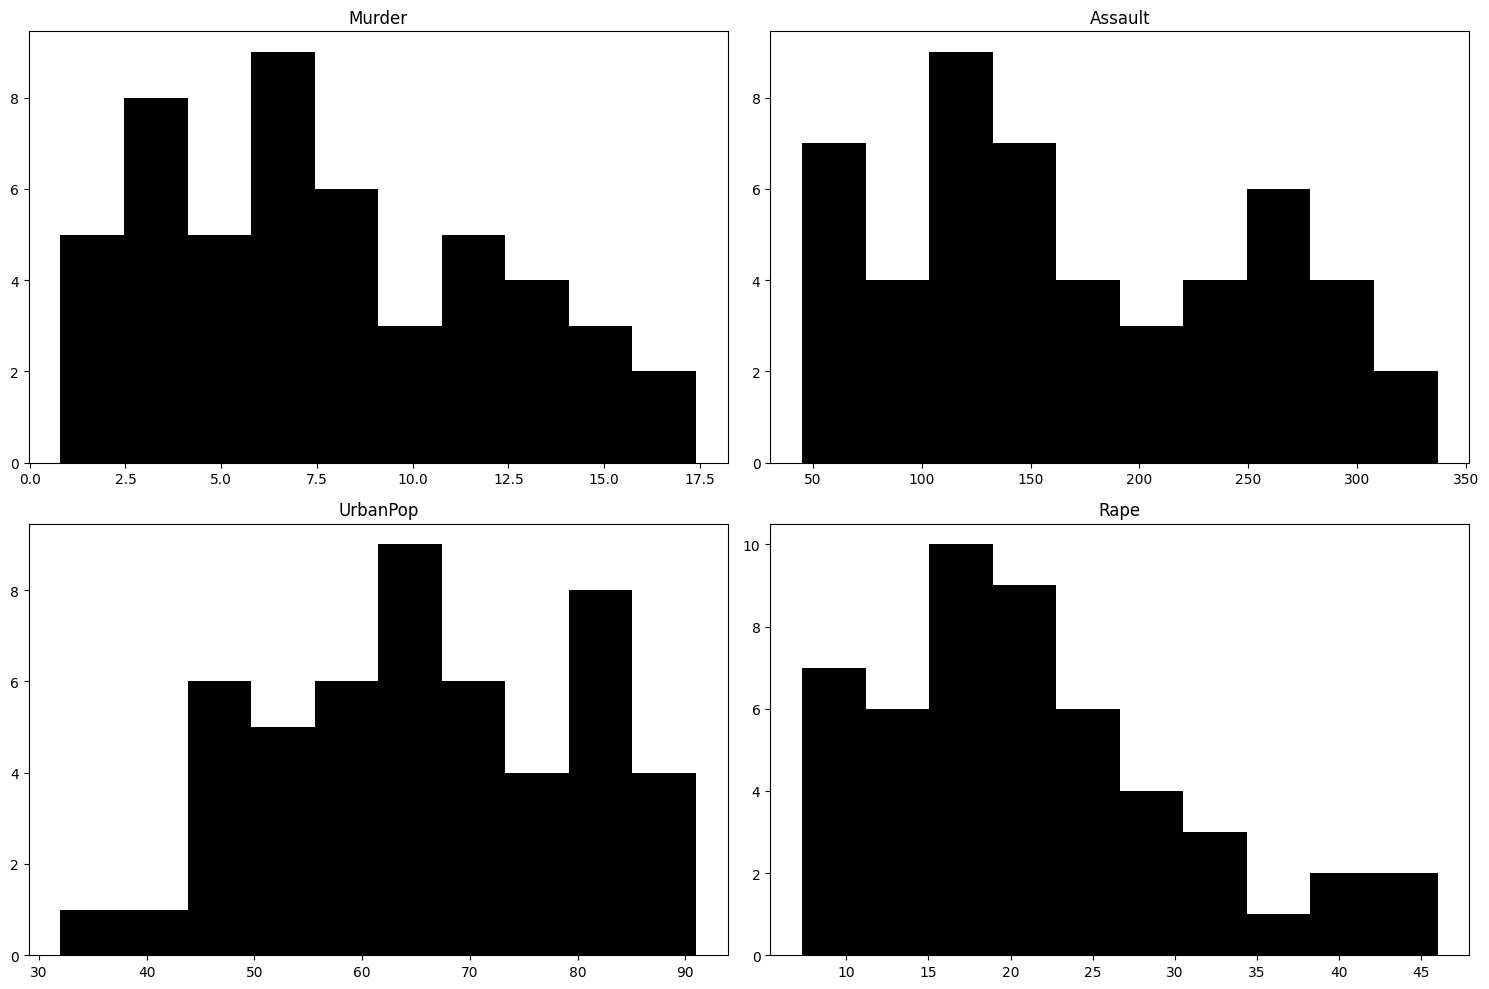

In [33]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

In [34]:
# Extracting the numerrical variables
X = df.iloc[:, 1:].values

# Standardizing
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)


The correlational model indicates that assault and murder were relatively strongly positively correlated, while rape and other crime indexes were weakly correlated with Urban Population (UrbanPop) not significantly correlated with crime rates.

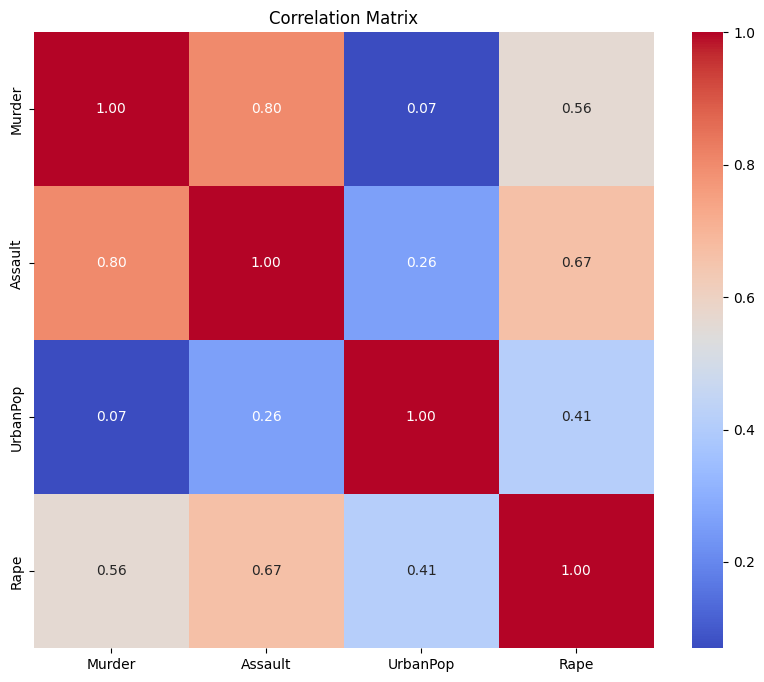

In [35]:
# Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The PCA performed reduced dimensionality and visualize the data. The first two principal components captured most of the variance (half of the variance was explained). Scatter plots of these two variables revealed an underlying pattern in the data, suggesting that they could be distinguished between countries by their crime statistics and urban areas



In [36]:
# Creating an instance of PCA class
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X)

# Explained variance
print("Explained variance ratio by components:", pca.explained_variance_ratio_)


Explained variance ratio by components: [0.96638123 0.02783586]


In [39]:
np.set_printoptions(precision=2)
pca = PCA()
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2
0,64.632127,-11.343397,-2.669411
1,92.814628,-18.064201,20.405845
2,124.163713,8.613018,-1.338369
3,18.312861,-16.710414,0.264993
4,107.466988,22.395697,6.933096


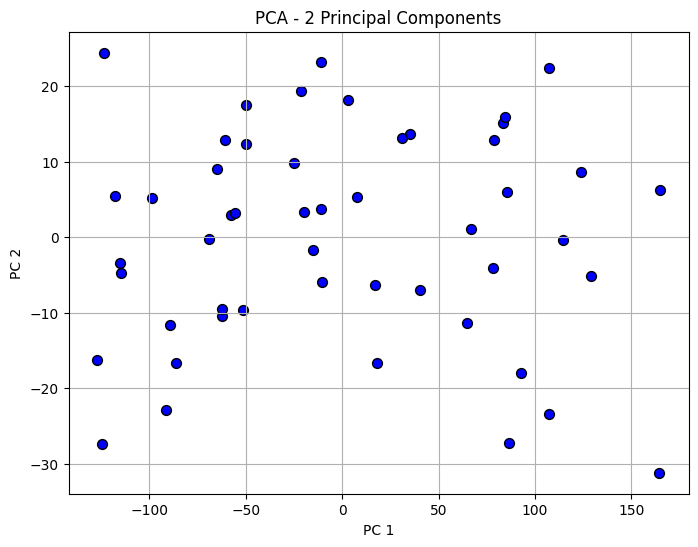

In [37]:
# Scatter plot of the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', edgecolor='k', s=50)
plt.title("PCA - 2 Principal Components")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

K-Means Clustering of clustered states into clusters based on crime rate and urban population. The silhouette score shows that the clustering was meaningful.

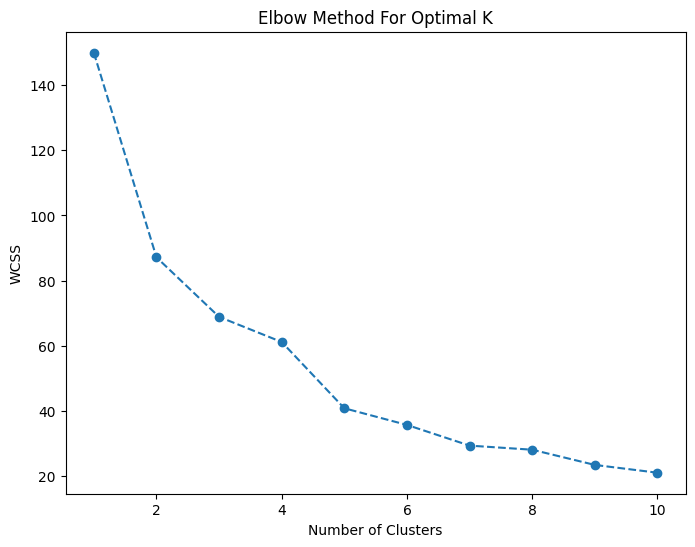

In [40]:
# Clustering Analysis

# K-Means Clustering
# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center

plt.figure(figsize=(8,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method For Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [41]:
# Perform K-Means with an optimal number of clusters (e.g., K=4 based on Elbow)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(data_scaled)

In [42]:
# Silhouette Score
sil_score = silhouette_score(data_scaled, kmeans_clusters)
print(f'Silhouette Score for K-Means: {sil_score}')

Silhouette Score for K-Means: 0.27288106573301957


The Hierarchical clustering that I  performed, and a dendrogram visually indicats how states could be clustered hierarchically. In this way, four clusters were also selected, corresponding to the K-means results.

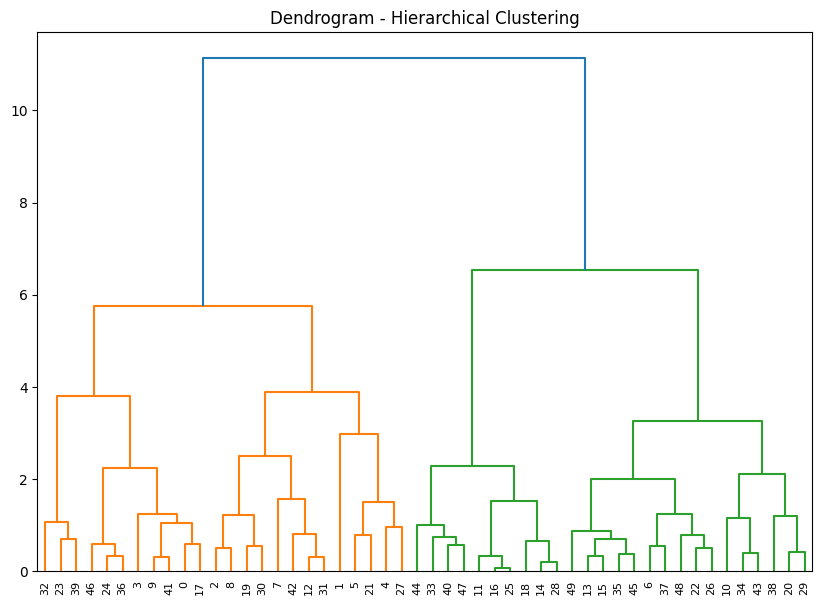

In [43]:
# Hierarchical Clustering (Agglomerative)
linked = linkage(data_scaled, method='ward')

# Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df.index.tolist())
plt.title("Dendrogram - Hierarchical Clustering")
plt.show()

In [44]:
# Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
hc_clusters = hc.fit_predict(data_scaled)

In [45]:
# Adding the clusters to the original dataset
df['KMeans_Cluster'] = kmeans_clusters
df['HC_Cluster'] = hc_clusters

In [46]:
# Examine common patterns within clusters
for cluster in range(4):
    print(f"\nK-Means Cluster {cluster}:\n", X[df['KMeans_Cluster'] == cluster].mean())


K-Means Cluster 0:
 50.8921568627451

K-Means Cluster 1:
 125.26666666666667

K-Means Cluster 2:
 118.5

K-Means Cluster 3:
 91.93333333333332


**Cluster analysis**

Each group showed a distinct pattern: groups with high murder and assault rates tended to include states with high urban populations, while others had low crime but urban States within the same group shared similar socio-geographic characteristics such as crime rate and population density .